In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)


In [18]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]


In [33]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

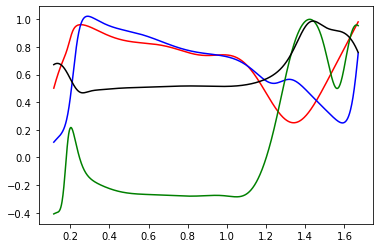

In [20]:
interpolMeanNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolVarNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolSkwNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolKurtNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolMeanNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolMean_64_64.pth"))
interpolVarNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolVar_64_64.pth"))
interpolSkwNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolSkw_64_64.pth"))
interpolKurtNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolKurt_64_64.pth"))

interpolMeanNN.eval()
interpolVarNN.eval()
interpolSkwNN.eval()
interpolKurtNN.eval()

x_test = torch.unsqueeze(torch.linspace(0.1156, 1.670, 1000), dim=1).double()
y_test1 = interpolMeanNN(x_test)
y_test2 = interpolVarNN(x_test)
y_test3 = interpolSkwNN(x_test)
y_test4 = interpolKurtNN(x_test)


plt.plot(x_test, y_test1.detach().numpy(), 'r')
plt.plot(x_test, y_test2.detach().numpy(), 'b')
plt.plot(x_test, y_test3.detach().numpy(), 'g')
plt.plot(x_test, y_test4.detach().numpy(), 'k')
plt.show()

In [21]:
from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
tTrain_dummy = torch.tensor(tTrain, dtype=torch.double)
tTrain_dummy = torch.unsqueeze(tTrain_dummy, dim=1)
xTrainMean = interpolMeanNN(tTrain_dummy)
xTrainVar = interpolVarNN(tTrain_dummy)
xTrainSkw = interpolSkwNN(tTrain_dummy)
xTrainKurt = interpolKurtNN(tTrain_dummy)
xTrain = torch.cat((xTrainMean,xTrainVar,xTrainSkw,xTrainKurt,tTrain_dummy),dim=1).detach().numpy()
# quad_interp = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
# xTrain = quad_interp(tTrain) 

In [22]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

In [23]:
clear true_y 

In [24]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

In [25]:
# s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
# batch_y0 = true_y[s]  # (M, D)
# batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
# batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
# batch_y=batch_y.permute(2,0,1,3)

In [26]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [27]:
## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncMean(nn.Module):

#     def __init__(self):
#         super(ODEFuncMean, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         ).to(torch.float64)

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcMean = ODEFuncMean().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncVariance(nn.Module):

#     def __init__(self):
#         super(ODEFuncVariance, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcVariance = ODEFuncVariance().to(device)

## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncSkewness(nn.Module):

    def __init__(self):
        super(ODEFuncSkewness, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcSkewness = ODEFuncSkewness().to(device)

# ## Construct a neural network to approximate the dynamics of an ODE
# class ODEFuncKurtosis(nn.Module):

#     def __init__(self):
#         super(ODEFuncKurtosis, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(5, 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
    
# funcKurtosis = ODEFuncKurtosis().to(device)
    
def combined_system(tVar, y):
    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])
    
    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
    
    ds_dt = funcSkewness(tVar, y)
        
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [28]:
ii = 0
## Setting up the optimizer

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(funcSkewness.parameters(), lr=0.005)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,2].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,2]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,2].unsqueeze(1)
                actual_toDisplay = true_y[:,:,2]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 2.676489
Iter 0020 | Total Loss 1.345980
Iter 0040 | Total Loss 1.114610
Iter 0060 | Total Loss 0.804532
Iter 0080 | Total Loss 0.949382
Iter 0100 | Total Loss 0.362649
Iter 0120 | Total Loss 1.199652
Iter 0140 | Total Loss 0.805610
Iter 0160 | Total Loss 1.031109
Iter 0180 | Total Loss 0.165509
Iter 0200 | Total Loss 0.177892
Iter 0220 | Total Loss 0.295499
Iter 0240 | Total Loss 0.328642
Iter 0260 | Total Loss 0.309191
Iter 0280 | Total Loss 0.350282
Iter 0300 | Total Loss 0.256780
Iter 0320 | Total Loss 0.131905
Iter 0340 | Total Loss 0.130346
Iter 0360 | Total Loss 0.122726
Iter 0380 | Total Loss 0.102334
Iter 0400 | Total Loss 0.098927
Iter 0420 | Total Loss 0.217661
Iter 0440 | Total Loss 0.329526
Iter 0460 | Total Loss 0.112083
Iter 0480 | Total Loss 0.115890
Iter 0500 | Total Loss 0.173703
Iter 0520 | Total Loss 0.129001
Iter 0540 | Total Loss 0.162507
Iter 0560 | Total Loss 0.267725
Iter 0580 | Total Loss 0.269191


KeyboardInterrupt: 

In [29]:
optimizer = optim.RMSprop(funcSkewness.parameters(), lr=0.0005)

for itr in range(600, 2000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,2].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,2]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,2].unsqueeze(1)
                actual_toDisplay = true_y[:,:,2]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0600 | Total Loss 0.277007
Iter 0620 | Total Loss 0.158534
Iter 0640 | Total Loss 0.170705
Iter 0660 | Total Loss 0.156190
Iter 0680 | Total Loss 0.142200
Iter 0700 | Total Loss 0.153658
Iter 0720 | Total Loss 0.135844
Iter 0740 | Total Loss 0.136792
Iter 0760 | Total Loss 0.139895
Iter 0780 | Total Loss 0.125441
Iter 0800 | Total Loss 0.137907
Iter 0820 | Total Loss 0.130898
Iter 0840 | Total Loss 0.126850
Iter 0860 | Total Loss 0.114651
Iter 0880 | Total Loss 0.126472
Iter 0900 | Total Loss 0.135021
Iter 0920 | Total Loss 0.146990
Iter 0940 | Total Loss 0.132827
Iter 0960 | Total Loss 0.122990
Iter 0980 | Total Loss 0.127833
Iter 1000 | Total Loss 0.095296
Iter 1020 | Total Loss 0.134681
Iter 1040 | Total Loss 0.122429
Iter 1060 | Total Loss 0.122649
Iter 1080 | Total Loss 0.111989
Iter 1100 | Total Loss 0.110928
Iter 1120 | Total Loss 0.109625
Iter 1140 | Total Loss 0.112212
Iter 1160 | Total Loss 0.097564
Iter 1180 | Total Loss 0.133125
Iter 1200 | Total Loss 0.115007
Iter 122

In [32]:
optimizer = optim.RMSprop(funcSkewness.parameters(), lr=0.0001)

for itr in range(2000, 4000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,2].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,2]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,2].unsqueeze(1)
                actual_toDisplay = true_y[:,:,2]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 2000 | Total Loss 0.110673
Iter 2020 | Total Loss 0.083485
Iter 2040 | Total Loss 0.091508
Iter 2060 | Total Loss 0.090530
Iter 2080 | Total Loss 0.095097
Iter 2100 | Total Loss 0.094847
Iter 2120 | Total Loss 0.090011
Iter 2140 | Total Loss 0.095199
Iter 2160 | Total Loss 0.091668
Iter 2180 | Total Loss 0.088869
Iter 2200 | Total Loss 0.093333
Iter 2220 | Total Loss 0.093964
Iter 2240 | Total Loss 0.090090
Iter 2260 | Total Loss 0.092128
Iter 2280 | Total Loss 0.087153
Iter 2300 | Total Loss 0.089721
Iter 2320 | Total Loss 0.088597
Iter 2340 | Total Loss 0.093027
Iter 2360 | Total Loss 0.088226
Iter 2380 | Total Loss 0.087104
Iter 2400 | Total Loss 0.089921
Iter 2420 | Total Loss 0.088845
Iter 2440 | Total Loss 0.090576
Iter 2460 | Total Loss 0.082043
Iter 2480 | Total Loss 0.085697
Iter 2500 | Total Loss 0.085783
Iter 2520 | Total Loss 0.087318
Iter 2540 | Total Loss 0.091100
Iter 2560 | Total Loss 0.088599
Iter 2580 | Total Loss 0.087929
Iter 2600 | Total Loss 0.086332
Iter 262

KeyboardInterrupt: 

In [34]:
optimizer = optim.RMSprop(funcSkewness.parameters(), lr=0.0001)

for itr in range(2840, 4000):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,2].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,2]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,2].unsqueeze(1)
                actual_toDisplay = true_y[:,:,2]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 2840 | Total Loss 0.124839
Iter 2860 | Total Loss 0.083092
Iter 2880 | Total Loss 0.090074
Iter 2900 | Total Loss 0.086168
Iter 2920 | Total Loss 0.087860
Iter 2940 | Total Loss 0.085502
Iter 2960 | Total Loss 0.087430
Iter 2980 | Total Loss 0.086623
Iter 3000 | Total Loss 0.087012
Iter 3020 | Total Loss 0.087822
Iter 3040 | Total Loss 0.082441
Iter 3060 | Total Loss 0.088877
Iter 3080 | Total Loss 0.081763
Iter 3100 | Total Loss 0.087728
Iter 3120 | Total Loss 0.083977
Iter 3140 | Total Loss 0.083528
Iter 3160 | Total Loss 0.079672
Iter 3180 | Total Loss 0.088445
Iter 3200 | Total Loss 0.082252
Iter 3220 | Total Loss 0.083352
Iter 3240 | Total Loss 0.080178
Iter 3260 | Total Loss 0.078683
Iter 3280 | Total Loss 0.078714
Iter 3300 | Total Loss 0.080302
Iter 3320 | Total Loss 0.083315
Iter 3340 | Total Loss 0.081805
Iter 3360 | Total Loss 0.081641
Iter 3380 | Total Loss 0.081890


KeyboardInterrupt: 

NameError: name 'temp_x_t_m_p2' is not defined

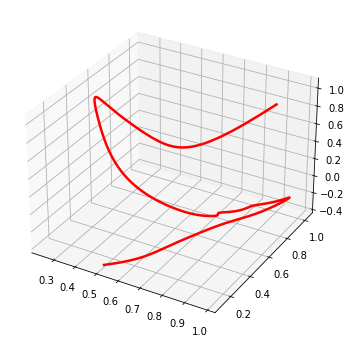

In [35]:
# Assuming ODEFunc is the name of your neural network class
#modelMean = funcMean
# modelVar = funcVariance
modelSkw = funcSkewness
# modelKurt = funcKurtosis


#modelMean.eval()
# modelVar.eval()
modelSkw.eval()
#modelKurt.eval()


# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

#ax.plot(x_train[:, 1], x_train[:, 2], x_train[:, 3], "k*", label="$given$")

ax.plot(predicted_states[:, 0], predicted_states[:, 1], predicted_states[:, 2], "r", label="$Neural-ODE-model$", linewidth=2.5,alpha =1)
ax.plot(temp_x_t_m_p2[:, 0], temp_x_t_m_p2[:, 1], temp_x_t_m_p2[:, 2], "b", label="True value", linewidth=2.5,alpha =0.6)
ax.set(xlabel="$Var$", ylabel="$Skw$", zlabel="$Kur$")
ax.legend()
fig.show()

#z_true = true_y[:,0,2].numpy()

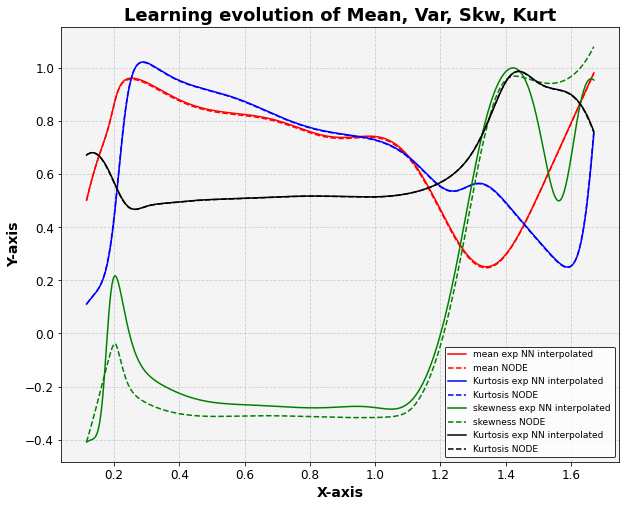

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrain[:,0], 'r',label='mean exp NN interpolated')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain,xTrain[:,1], 'b',label='Kurtosis exp NN interpolated')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='Kurtosis NODE')

plt.plot(tTrain,xTrain[:,2], 'g',label='skewness exp NN interpolated')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain,xTrain[:,3], 'k',label='Kurtosis exp NN interpolated')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=9)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('NN_Kurt_all_parts.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [37]:
torch.save(funcSkewness, 'skewness.pth')

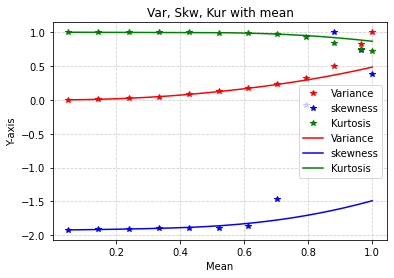

In [29]:
# Create a plot with different labels for each column
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 1], 'r*',label='Variance')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 2], 'b*',label='skewness')
plt.plot(temp_m_t_p1, temp_x_t_m_p1[:, 3], 'g*',label='Kurtosis')

plt.plot(t, predicted_states[:, 1], 'r',label='Variance')
plt.plot(t, predicted_states[:, 2], 'b',label='skewness')
plt.plot(t, predicted_states[:, 3], 'g',label='Kurtosis')

# Add labels and title
plt.xlabel('Mean')
plt.ylabel('Y-axis')
plt.title('Var, Skw, Kur with mean')

# Add a legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

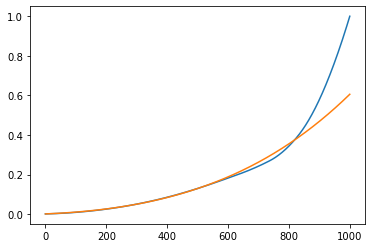

In [21]:
plt.plot(x_t_m_p1[:,1])
plt.plot(predicted_states[:,1])

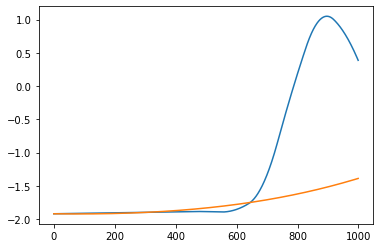

In [22]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

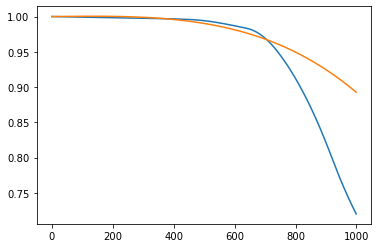

In [24]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])

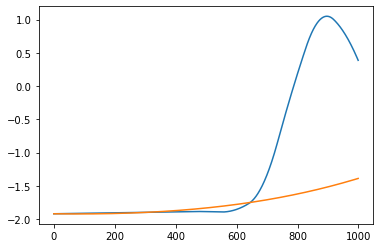

In [18]:
plt.plot(x_t_m_p1[:,2])
plt.plot(predicted_states[:,2])

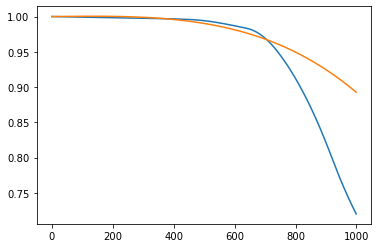

In [19]:
plt.plot(x_t_m_p1[:,3])
plt.plot(predicted_states[:,3])